In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import gwpy
from gwpy.timeseries import TimeSeries
from numpy import *
import numpy as np
from scipy import signal
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle
import pylab


In [3]:
params=open("parameters.txt","r")

y = yaml.load(params)
cha=y['channels'].split(',')
print cha

['ASC-INP2_P_IN1_DQ', 'ASC-PRC1_P_IN1_DQ', 'ASC-PRC2_P_IN1_DQ', 'ASC-MICH_P_IN1_DQ', 'ASC-SRC1_P_IN1_DQ', 'ASC-SRC2_P_IN1_DQ', 'ASC-DHARD_P_IN1_DQ', 'ASC-DSOFT_P_IN1_DQ', 'ASC-CSOFT_P_IN1_DQ', 'ASC-DC1_P_IN1_DQ', 'ASC-DC2_P_IN1_DQ', 'ASC-DC3_P_IN1_DQ', 'ASC-DC4_P_IN1_DQ', 'ASC-DC5_P_IN1_DQ', 'SUS-OM1_M1_DAMP_P_IN1_DQ', 'SUS-OM2_M1_DAMP_P_IN1_DQ', 'SUS-OM3_M1_DAMP_P_IN1_DQ', 'SUS-OMC_M1_DAMP_P_IN1_DQ', 'ASC-INP2_Y_IN1_DQ', 'ASC-PRC1_Y_IN1_DQ', 'ASC-PRC2_Y_IN1_DQ', 'ASC-MICH_Y_IN1_DQ', 'ASC-SRC1_Y_IN1_DQ', 'ASC-SRC2_Y_IN1_DQ', 'ASC-DHARD_Y_IN1_DQ', 'ASC-DSOFT_Y_IN1_DQ', 'ASC-CSOFT_Y_IN1_DQ', 'ASC-DC1_Y_IN1_DQ', 'ASC-DC2_Y_IN1_DQ', 'ASC-DC3_Y_IN1_DQ', 'ASC-DC4_Y_IN1_DQ', 'ASC-DC5_Y_IN1_DQ', 'SUS-OM1_M1_DAMP_Y_IN1_DQ', 'SUS-OM2_M1_DAMP_Y_IN1_DQ', 'SUS-OM3_M1_DAMP_Y_IN1_DQ', 'SUS-OMC_M1_DAMP_Y_IN1_DQ']


In [4]:
#Get Data

params = yaml.load(open("parameters.txt","r"))
ch_list = params['channels'].split(',')
gps_s = params['GPS_start']
dur = params['duration']
data={}

for ch in ch_list:
    data[ch] = TimeSeries.get('L1:%s.mean,s-trend' % ch,gps_s,gps_s+dur)
    

3627


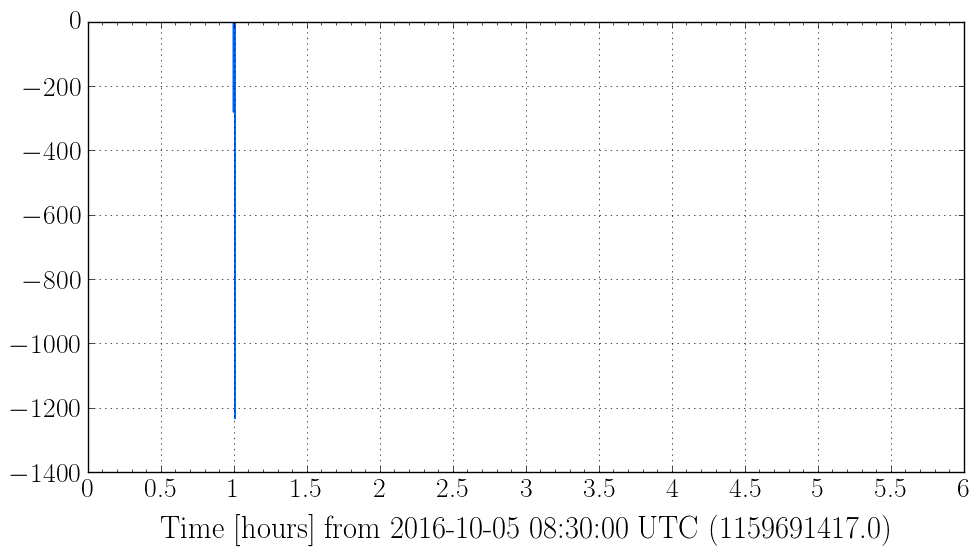

In [34]:
fig_test=abs(data['ASC-DC5_P_IN1_DQ']).argmax()
print fig_test
#fig_test.show()

plot_test=data['ASC-DC5_P_IN1_DQ'].plot()
#plot_test.set_xlim([3500,3700])
plot_test.show()

In [5]:
#Storing data dictionary into another file for later use
with open("raw_data.txt", "wb") as myFile:
    pickle.dump(data, myFile)

In [7]:
#If needed, load previously saved file containing time series data
data = pickle.load(open("raw_data.txt", "rb" ))


In [6]:
#Subtracting out the mean and dividing by the standard deviation for each channel
data_lp={}
data_hp={}

for key, value in data.iteritems(): 
    v = value
    #Apply low pass filter to data.
    filt_low=gwpy.timeseries.TimeSeries.lowpass(v-v[:600].mean(), 1./180, gstop=20, stop=2./180)[900:]
    
    
    meanaux_low=filt_low.mean() 
    stdaux_low=np.std(filt_low)
    datasub_low=np.subtract(filt_low, meanaux_low)
    datadiv_low=np.divide(datasub_low, stdaux_low) 
    
    #Apply high pass filter to data
    filt_high=gwpy.timeseries.TimeSeries.highpass(v, 1./300)[900:]
    
    meanaux_high=filt_high.mean() 
    stdaux_high=np.std(filt_high)
    datasub_high=np.subtract(filt_high, meanaux_high)
    datadiv_high=np.divide(datasub_high, stdaux_high)
    
    data_lp[key] = datadiv_low
    data_hp[key] = datadiv_high
    
#How to print out variable from dic....
#print datanew['dataOMCY']


In [7]:
#Storing cleaned data in list m_A
m_A_lp=[]
m_A_hp=[]

for ch in ch_list:
    m_A_lp.append(data_lp[ch])
            
for ch in ch_list:
    m_A_hp.append(data_hp[ch])
    
len(m_A_lp)

36

In [17]:
print m_A_lp[13]
print m_A_lp[26]

TimeSeries([ 0.06507924, 0.06504047, 0.06500219,...,  0.07047251,
             0.07044942, 0.07043016]
           unit: Unit(dimensionless),
           name: 'L1:ASC-DC5_P_IN1_DQ.mean',
           channel: <Channel("L1:ASC-DC5_P_IN1_DQ.mean" [s-trend], 1.0 Hz) at 0x10870d190>,
           x0: <Quantity 1159692317.0 s>,
           dx: <Quantity 1.0 s>)
TimeSeries([-1.700551  ,-1.70053378,-1.70051161,...,  0.87675556,
             0.87656557, 0.87637234]
           unit: Unit(dimensionless),
           name: 'L1:ASC-CSOFT_Y_IN1_DQ.mean',
           channel: <Channel("L1:ASC-CSOFT_Y_IN1_DQ.mean" [s-trend], 1.0 Hz) at 0x1086e83d0>,
           x0: <Quantity 1159692317.0 s>,
           dx: <Quantity 1.0 s>)


In [9]:
#Applying PCA to cleaned data
A_lp = np.column_stack(m_A_lp)
A_hp = np.column_stack(m_A_hp)

pca_lp = PCA(n_components=20)
pca_hp = PCA(n_components=20)

X_r_lp = pca_lp.fit(A_lp).transform(A_lp)
X_r_hp = pca_hp.fit(A_hp).transform(A_hp)

#Dump results into a file
with open("results.txt", "wb") as myFile:
    pickle.dump(X_r_lp, myFile)
    pickle.dump(X_r_hp, myFile)
print X_r_lp
#print X_r_hp

print('explained variance ratio (first twenty components): %s'
      % str(pca_lp.explained_variance_ratio_))


[[ 3.7252461  -3.57177025  1.26934491 ..., -0.79873138
   0.90228126  0.48813211]
 [ 3.72216463 -3.60447261  1.23071534 ..., -0.80382091
   0.96058259  0.49184209]
 [ 3.72077581 -3.63260065  1.18883484 ..., -0.80605424  1.0221789
   0.49512018]
 ..., 
 [-0.43202837 -2.45212112 -3.25451684 ...,  1.23843733
   0.38361545 -1.37481894]
 [-0.42570349 -2.46832277 -3.28858368 ...,  1.2757576   0.46507459
  -1.34275013]
 [-0.41854578 -2.48077019 -3.32646593 ...,  1.3137305   0.53799126
  -1.31452785]]
explained variance ratio (first twenty components): [ 0.22396048  0.10494483  0.09445108  0.08009567  0.05817046
  0.05236416  0.04600157  0.04046266  0.03731759  0.03179188
  0.02909448  0.02801565  0.02523033  0.02220561  0.01961336
  0.01769567  0.01611782  0.01495694  0.01269255  0.012031  ]


In [10]:
print ch_list

['ASC-INP2_P_IN1_DQ', 'ASC-PRC1_P_IN1_DQ', 'ASC-PRC2_P_IN1_DQ', 'ASC-MICH_P_IN1_DQ', 'ASC-SRC1_P_IN1_DQ', 'ASC-SRC2_P_IN1_DQ', 'ASC-DHARD_P_IN1_DQ', 'ASC-DSOFT_P_IN1_DQ', 'ASC-CSOFT_P_IN1_DQ', 'ASC-DC1_P_IN1_DQ', 'ASC-DC2_P_IN1_DQ', 'ASC-DC3_P_IN1_DQ', 'ASC-DC4_P_IN1_DQ', 'ASC-DC5_P_IN1_DQ', 'SUS-OM1_M1_DAMP_P_IN1_DQ', 'SUS-OM2_M1_DAMP_P_IN1_DQ', 'SUS-OM3_M1_DAMP_P_IN1_DQ', 'SUS-OMC_M1_DAMP_P_IN1_DQ', 'ASC-INP2_Y_IN1_DQ', 'ASC-PRC1_Y_IN1_DQ', 'ASC-PRC2_Y_IN1_DQ', 'ASC-MICH_Y_IN1_DQ', 'ASC-SRC1_Y_IN1_DQ', 'ASC-SRC2_Y_IN1_DQ', 'ASC-DHARD_Y_IN1_DQ', 'ASC-DSOFT_Y_IN1_DQ', 'ASC-CSOFT_Y_IN1_DQ', 'ASC-DC1_Y_IN1_DQ', 'ASC-DC2_Y_IN1_DQ', 'ASC-DC3_Y_IN1_DQ', 'ASC-DC4_Y_IN1_DQ', 'ASC-DC5_Y_IN1_DQ', 'SUS-OM1_M1_DAMP_Y_IN1_DQ', 'SUS-OM2_M1_DAMP_Y_IN1_DQ', 'SUS-OM3_M1_DAMP_Y_IN1_DQ', 'SUS-OMC_M1_DAMP_Y_IN1_DQ']


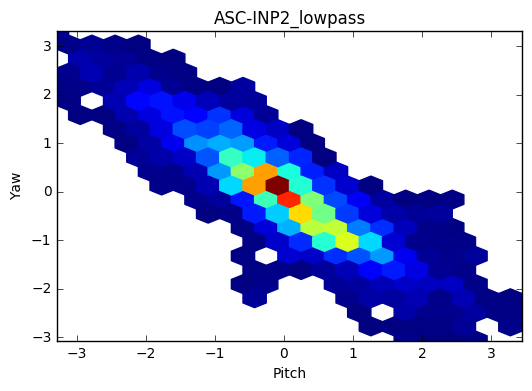

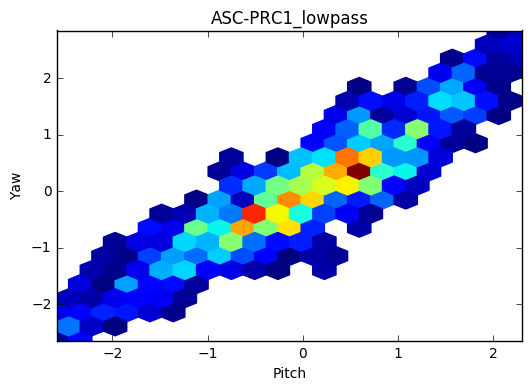

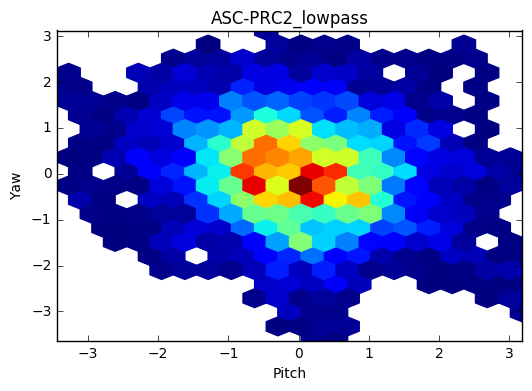

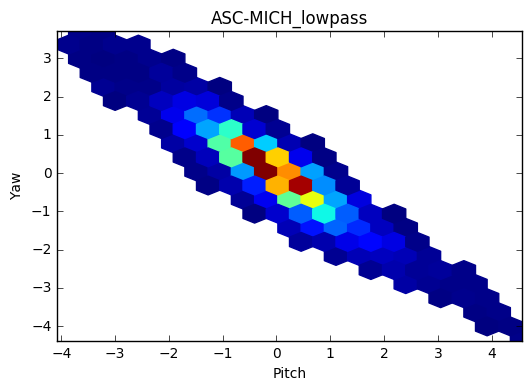

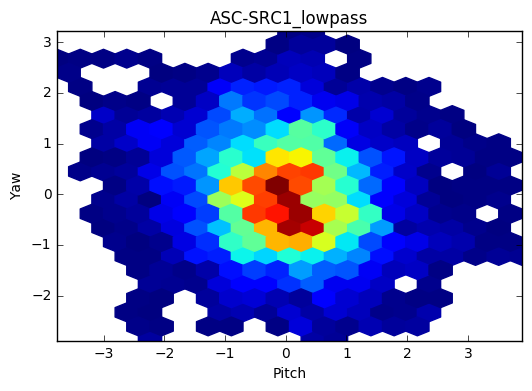

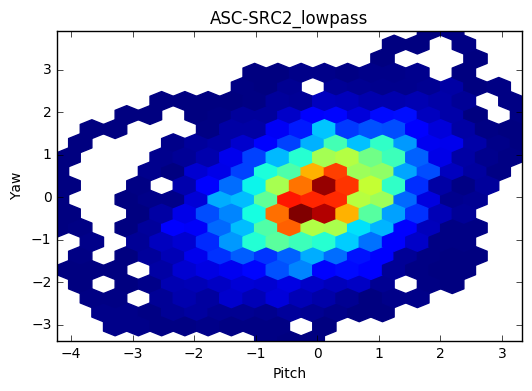

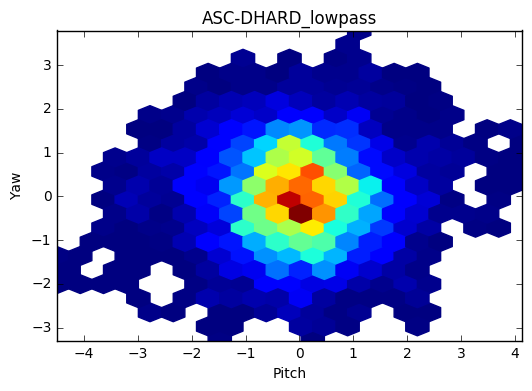

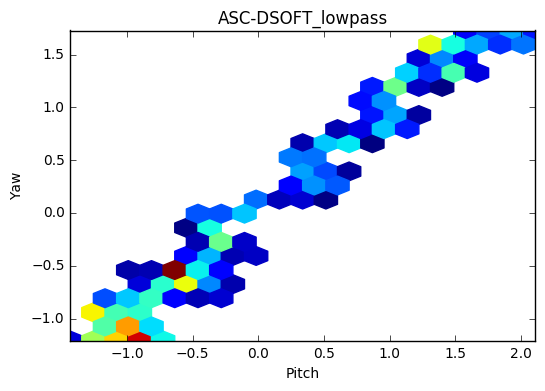

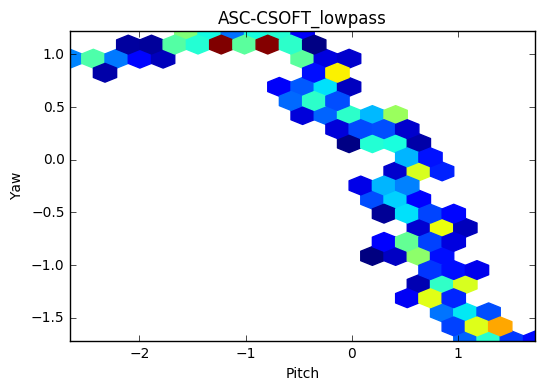

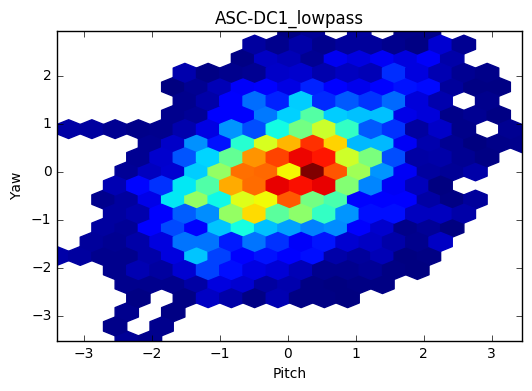

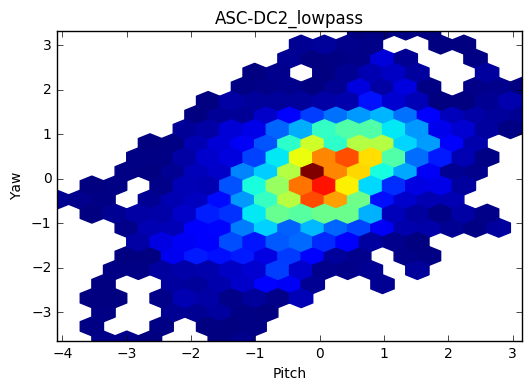

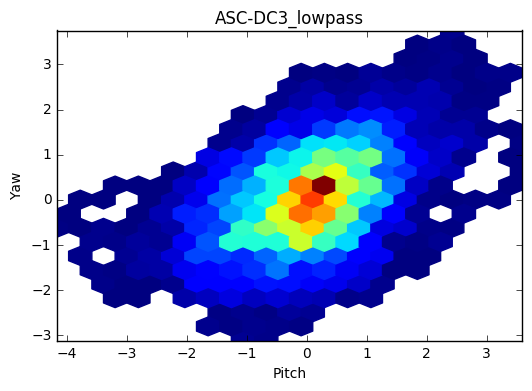

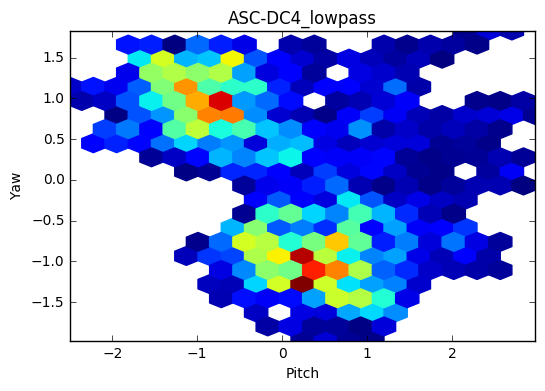

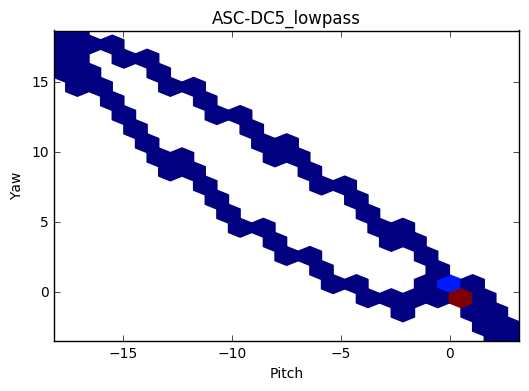

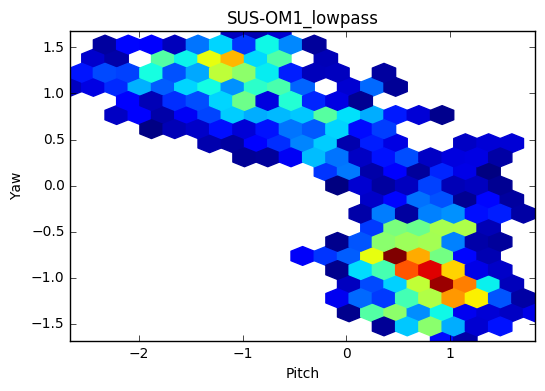

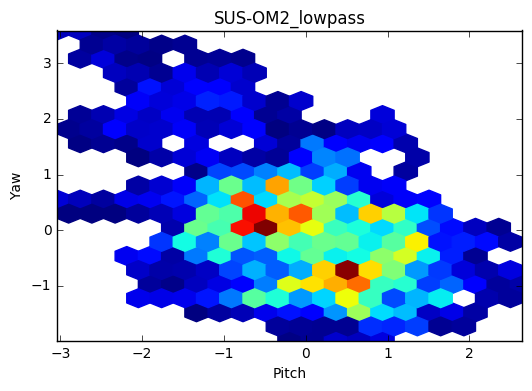

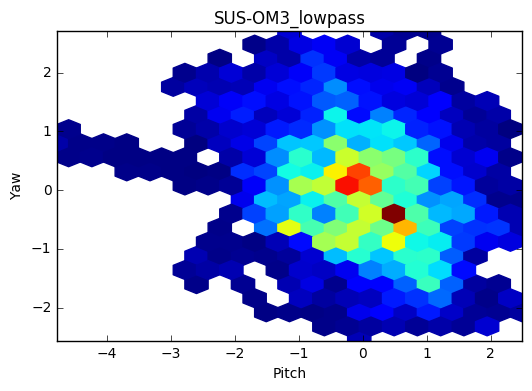

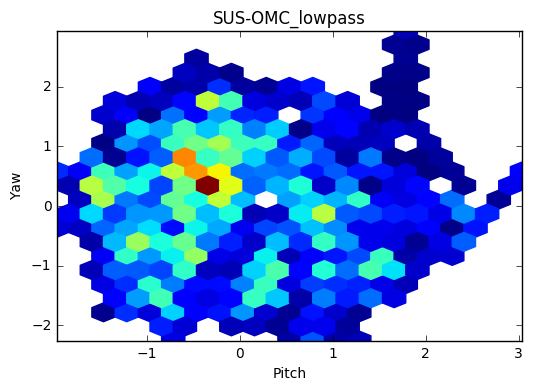

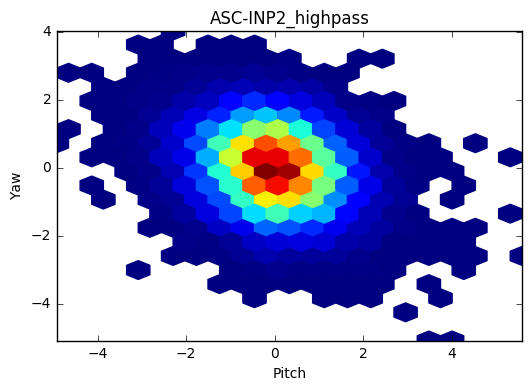

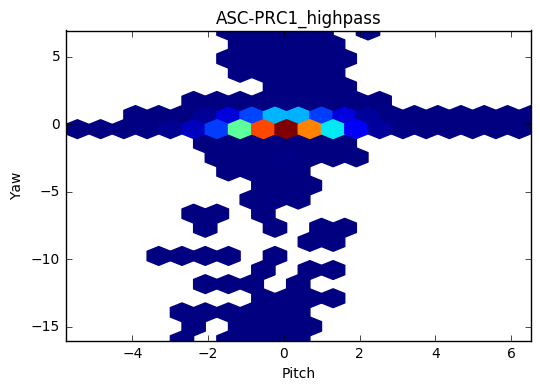

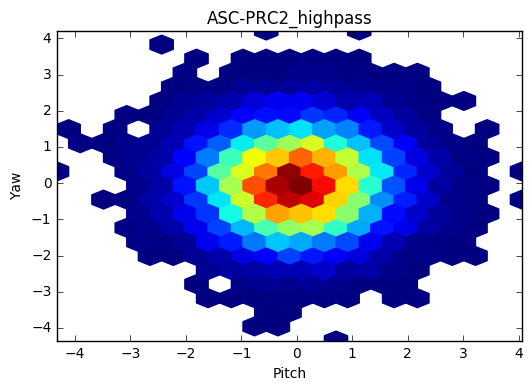

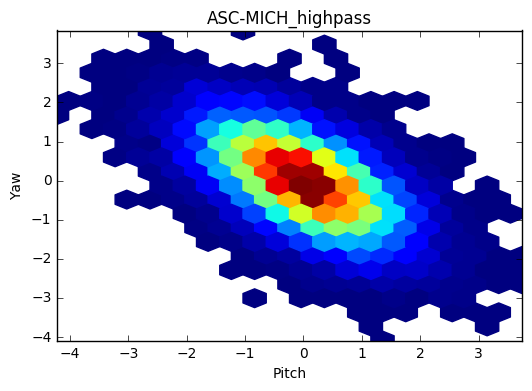

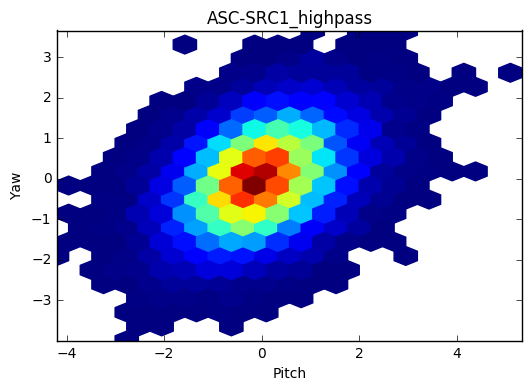

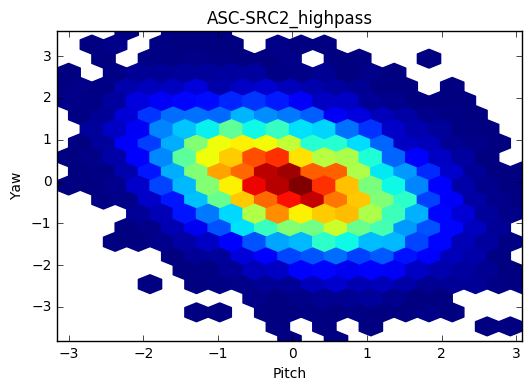

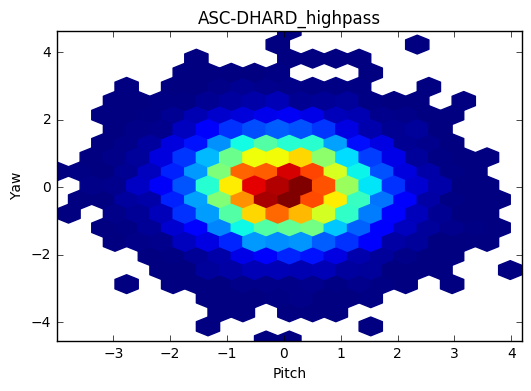

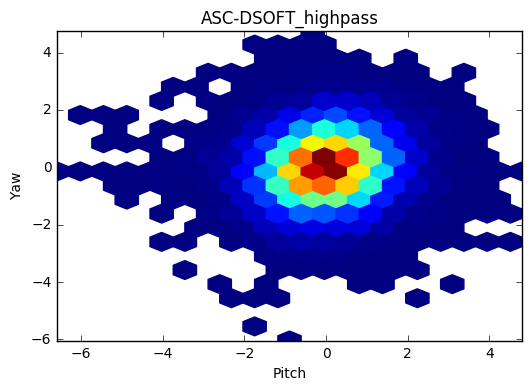

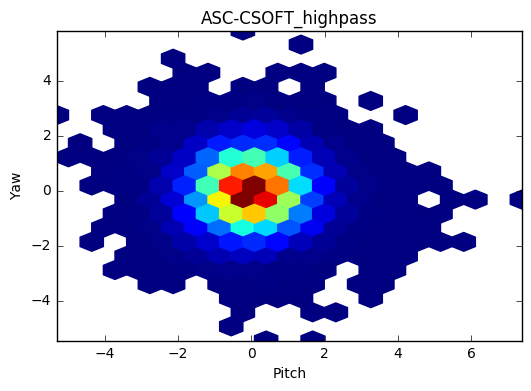

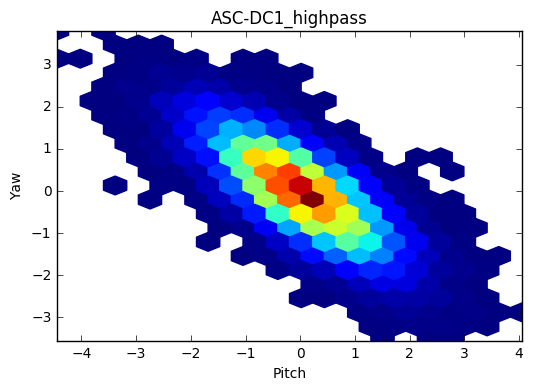

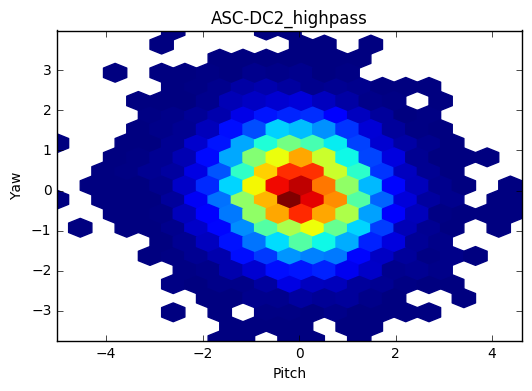

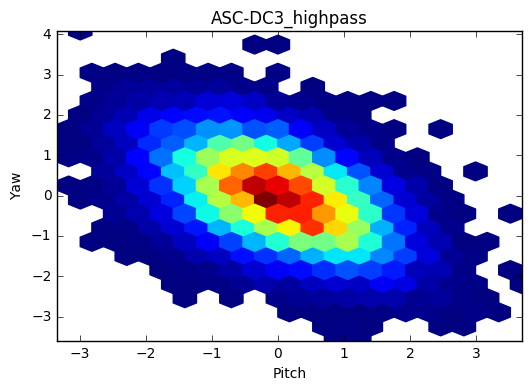

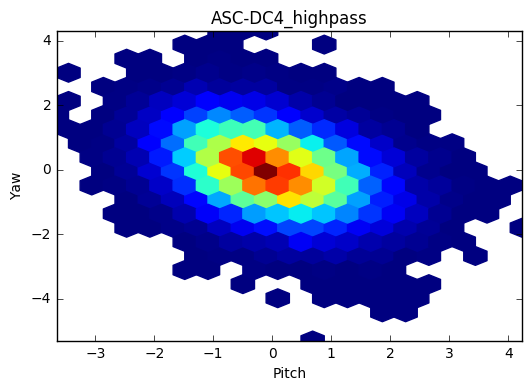

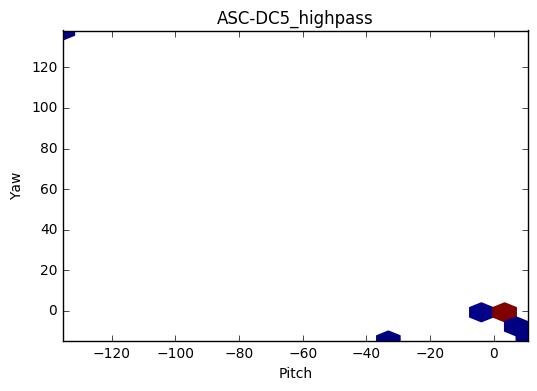

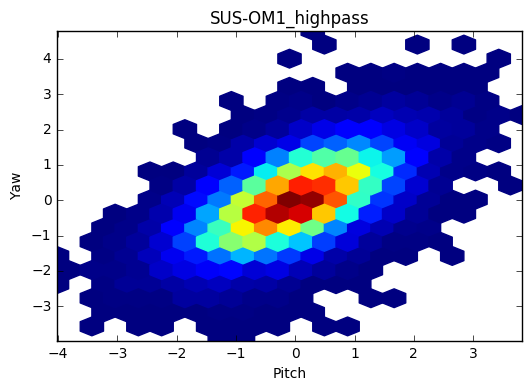

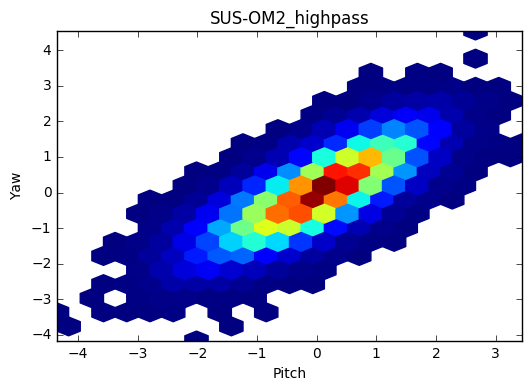

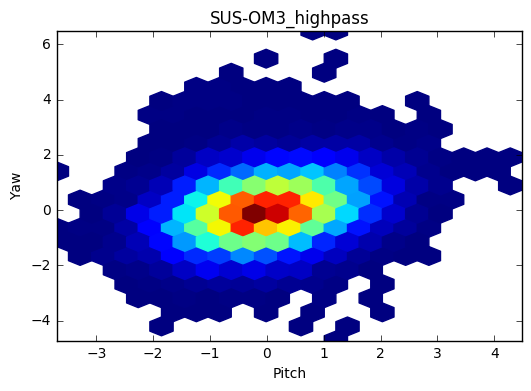

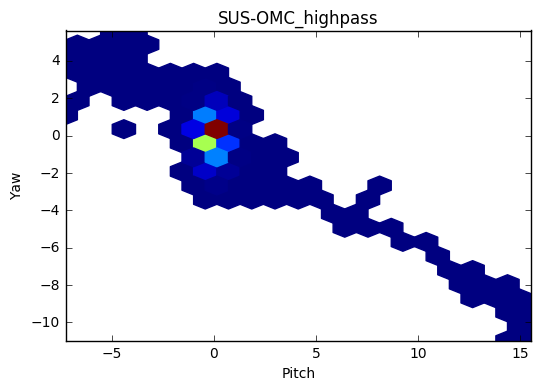

In [13]:
#Producing Density plots of each degree of freedom
for idx in range(0,len(ch_list)-18,1):
    plt.hexbin(A_lp[:,idx],A_lp[:,idx+18],gridsize=20, mincnt=1)
    plt.title('%s_lowpass' % ch_list[idx].split('_')[0])
    plt.xlabel('Pitch')
    plt.ylabel('Yaw')
    plt.show()
    plt.savefig('figs/%s_lp_density.png' % ch_list[idx].split('_')[0])
    
for idx in range(0,len(ch_list)-18,1):
    plt.hexbin(A_hp[:,idx],A_hp[:,idx+18],gridsize=20, mincnt=1)
    plt.title('%s_highpass' % ch_list[idx].split('_')[0])
    plt.xlabel('Pitch')
    plt.ylabel('Yaw')
    plt.show()
    plt.savefig('figs/%s_hp_density.png' % ch_list[idx].split('_')[0])

In [14]:
print best_ch_lp

NameError: name 'best_ch_lp' is not defined

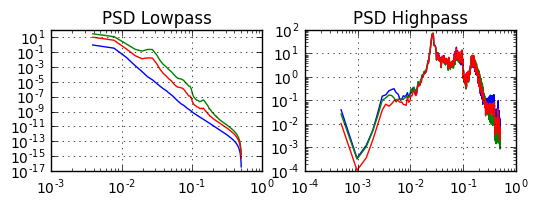

In [15]:
import matplotlib.pyplot as plt
#Determining Best Performing Channels in the first PC and then calculating the PSD

best_ch_lp = array(ch_list)[pca_lp.components_[0]**2>0.07]
best_ch_hp = array(ch_list)[pca_hp.components_[0]**2>0.07]

#Plottng the PSD of the best three performing channels
plt.figure(1)
if len(best_ch_lp)>=3:
    for idx in best_ch_lp[:3]:
        psd_lp = gwpy.timeseries.TimeSeries.psd(data_lp[idx],fftlength=256, overlap=128)
        plt.subplot(221)
        plt.loglog(psd_lp.frequencies, psd_lp.value)
        plt.title('PSD Lowpass')
        plt.grid(True)

elif len(best_ch_lp)<3:
    for idx in len(best_ch_lp):
        psd_lp = gwpy.timeseries.TimeSeries.psd(data_lp[idx],fftlength=256, overlap=128)
        plt.subplot(221)
        plt.loglog(psd_lp.frequencies, psd_lp.value)
        plt.title('PSD Lowpass')
        plt.grid(True)
    
if len(best_ch_hp)>=3:
    for idx in best_ch_hp[:3]:
        psd_hp = gwpy.timeseries.TimeSeries.psd(data_hp[idx],fftlength=2048, overlap=1024)
        plt.subplot(222)
        plt.loglog(psd_hp.frequencies, psd_hp.value)
        plt.title('PSD Highpass')
        plt.grid(True)

elif len(best_ch_hp)<3:
    for idx in len(best_ch_hp):
        psd_hp = gwpy.timeseries.TimeSeries.psd(data_hp[idx],fftlength=2048, overlap=1024)
        plt.subplot(222)
        plt.loglog(psd_hp.frequencies, psd_hp.value)
        plt.title('PSD Highpass')
        plt.grid(True)


#axarr[0].set_xlim([0,1400])

#axarr[0].set_title('Sharing X axis')

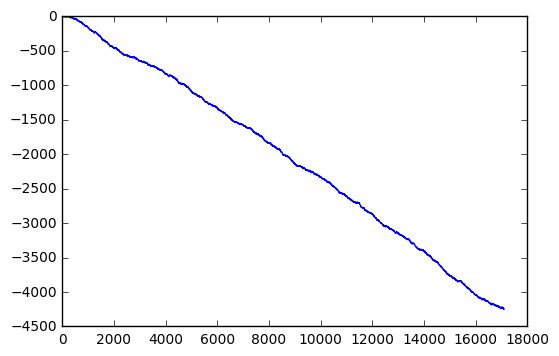

In [134]:
#plt.plot(unwrap(angle(X_r_hp[:,3]+1.j*X_r_hp[:,2])))

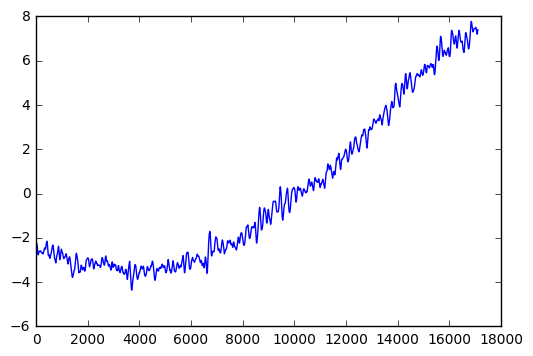

In [136]:
#plt.plot(X_r_lp[:,0])

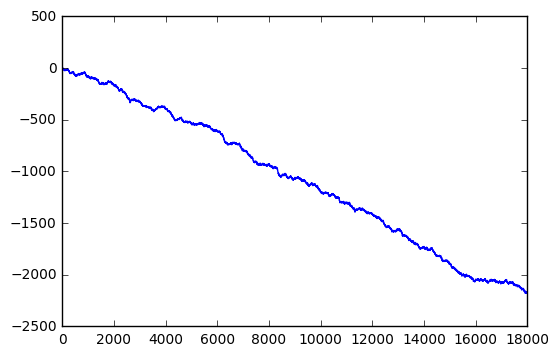

In [18]:
#plt.plot(unwrap(angle(X_r[:,2]+1.j*X_r[:,3])))

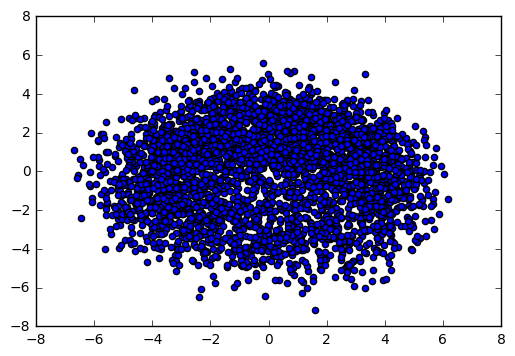

In [20]:
#plt.scatter(X_r[:,0],X_r[:,1])

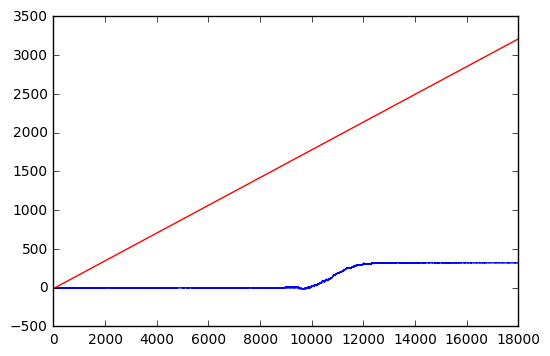

In [19]:
#tarr=arange(len(X_r[:,0]))
#plt.plot(unwrap(arctan2(X_r[:,1],X_r[:,0])))
#plt.plot(tarr,0.179*tarr-11.174,c='r')

In [22]:
#for idx in range(len(ch_list)):
#    print ch_list[idx], pca_lp.components_[0,idx:idx+2], pca_lp.components_[1,idx:idx+2]

ASC-INP2_P_IN1_DQ

NameError: name 'pca_lp' is not defined

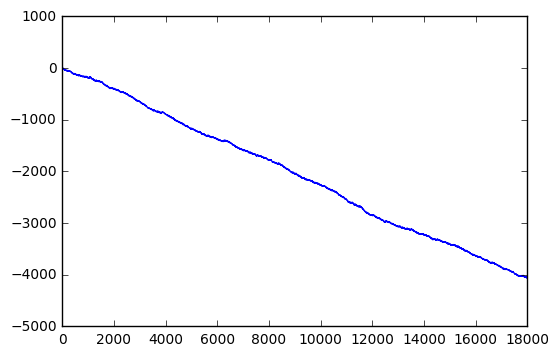

In [22]:
#plt.plot(unwrap(angle(X_r[:,1]+1.j*X_r[:,2])))

In [20]:
#polyfit(tarr,unwrap(angle(X_r[:,2]+1.j*X_r[:,3])),1)

array([ -0.12774962,  76.21326037])

In [74]:
#f01 = fft((X_r[:,2]+1.j*X_r[:,3])-mean(X_r[:,2]+1.j*X_r[:,3]))

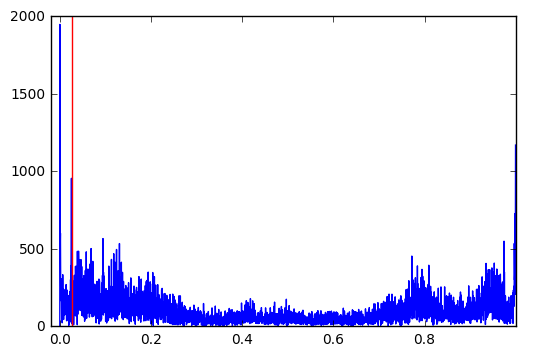

In [76]:
#plt.plot(arange(3600)/3600.,abs(f01))
#plt.gca().set_xlim(-.02,1)
#plt.gca().axvline(0.026,c='r')

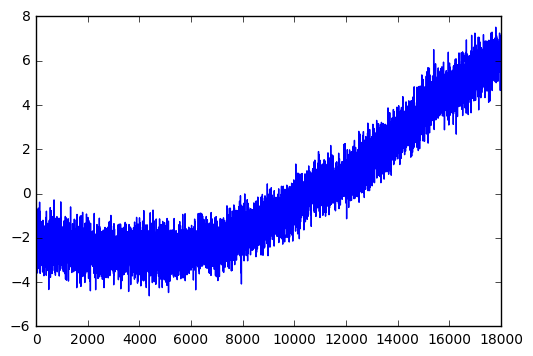

In [28]:
#plt.plot(X_r[:,0])

In [30]:
#pc0=pca.components_[0]
#pc1=pca.components_[1]
#pc2=pca.components_[2]

In [ ]:
if __name__ == "__main__":
    